<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-explore-the-data." data-toc-modified-id="Load-and-explore-the-data.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and explore the data.</a></span></li><li><span><a href="#Extract-samples-from-the-database-and-training-set." data-toc-modified-id="Extract-samples-from-the-database-and-training-set.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Extract samples from the database and training set.</a></span></li><li><span><a href="#Baseline---apply-the-sklearn-algorithm-to-the-samples." data-toc-modified-id="Baseline---apply-the-sklearn-algorithm-to-the-samples.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline - apply the sklearn algorithm to the samples.</a></span><ul class="toc-item"><li><span><a href="#Data-Standardization" data-toc-modified-id="Data-Standardization-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Standardization</a></span></li><li><span><a href="#Database-Clustering" data-toc-modified-id="Database-Clustering-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Database Clustering</a></span></li><li><span><a href="#Training-a-NearestNeighbors-model-for-each-cluster." data-toc-modified-id="Training-a-NearestNeighbors-model-for-each-cluster.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training a NearestNeighbors model for each cluster.</a></span></li></ul></li><li><span><a href="#Apply-the-FAISS-algorithm-to-the-samples." data-toc-modified-id="Apply-the-FAISS-algorithm-to-the-samples.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Apply the FAISS algorithm to the samples.</a></span><ul class="toc-item"><li><span><a href="#FAISS-with-the-parameters-from-the-baseline." data-toc-modified-id="FAISS-with-the-parameters-from-the-baseline.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>FAISS with the parameters from the baseline.</a></span></li><li><span><a href="#Changing-the-number-of-clusters." data-toc-modified-id="Changing-the-number-of-clusters.-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Changing the number of clusters.</a></span></li><li><span><a href="#Changing-the-scaling-method." data-toc-modified-id="Changing-the-scaling-method.-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Changing the scaling method.</a></span></li></ul></li><li><span><a href="#Implement-and-optimize-the-FAISS-algorithm-on-the-full-dataset." data-toc-modified-id="Implement-and-optimize-the-FAISS-algorithm-on-the-full-dataset.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Implement and optimize the FAISS algorithm on the full dataset.</a></span><ul class="toc-item"><li><span><a href="#Data-Standardization" data-toc-modified-id="Data-Standardization-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Data Standardization</a></span></li><li><span><a href="#IVF-Flat-L2" data-toc-modified-id="IVF-Flat-L2-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>IVF Flat L2</a></span></li><li><span><a href="#IVF-Flat-with-a-HNSW" data-toc-modified-id="IVF-Flat-with-a-HNSW-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>IVF Flat with a HNSW</a></span></li><li><span><a href="#IVF-with-a-PQ-index" data-toc-modified-id="IVF-with-a-PQ-index-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>IVF with a PQ index</a></span></li><li><span><a href="#Choosing-the-best-model." data-toc-modified-id="Choosing-the-best-model.-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Choosing the best model.</a></span></li></ul></li><li><span><a href="#Test-the-best-model." data-toc-modified-id="Test-the-best-model.-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test the best model.</a></span></li><li><span><a href="#General-Conclusions." data-toc-modified-id="General-Conclusions.-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>General Conclusions.</a></span></li></ul></div>

# Matching Products on a Marketplace

This project aims to solve the problem of matching products on a large marketplace.

The primary objective of the project is to develop an efficient product matching algorithm that can find the most relevant products from a database for each item in a query. The performance of the algorithm will be evaluated using the accuracy@5 metric.

**Data Description:**

The data provided for analysis consists of 4 sets:

* `base.csv` - the database - an anonymized set of products. Each product is represented by an unique id and a 72-dimensional feature vector.

* `train.csv` - the training dataset. Each row represents a product with an unique id and a feature vector. The id of the most similar product from the database is known.

* `validation.csv` - the validation dataset with products for which the equivalent products from the database need to be found.

* `validation_answer.csv` - the correct answers for the validation dataset.

**Work Plan:**

1. Load and explore the data.
2. Extract samples from the database and training set. 
3. Apply the `sklearn` algorithm to the samples. 
4. Apply the FAISS algorithm to the samples.
5. Implement and optimize the FAISS algorithm on the full dataset. 
6. Test the best model.

## Load and explore the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sweetviz as sv
import timeit

import faiss

from sklearn.preprocessing import(
    StandardScaler,
    RobustScaler
)
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score

import warnings

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams["figure.figsize"] = (10, 8)
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 12345
np.random.seed(RANDOM_STATE)

Let's read the data and display the top 5 rows.

In [4]:
data_base = pd.read_csv('data/base.csv', index_col=0)
data_base.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.08,11.15,-64.43,-118.88,216.48,-104.70,-469.07,44.35,120.92,181.45,-124.06,-32.46,-57.42,36.21,182.72,-28.07,-5.21,-1.73,-91.09,-79.47,-103.94,"1,507.23",-32.59,51.41,-51.91,813.77,-41.56,8.42,-129.98,148.77,-10.07,-143.01,79.85,-537.18,2.77,111.52,4.26,-153.34,-123.63,-39.71,-12.77,-4.17,-152.97,75.91,-57.47,17.27,-98.87,-138.07,91.00,-170.70,-50.02,59.79,78.11,-89.38,89.41,79.81,-129.51,-44.66,-80.44,5.15,-64.52,-138.78,-42.81,38.80,-151.76,-74.39,63.67,-4.70,92.93,115.27,-112.76,-60.83
1-base,-34.56,13.33,-69.79,-166.53,57.68,-86.10,-85.08,-35.64,119.72,195.23,-141.30,-126.77,-68.85,8.31,143.08,8.78,15.16,48.25,-244.95,-80.28,-81.79,429.88,-5.94,70.14,66.58,813.77,3.21,17.16,-39.42,148.16,-7.58,-174.37,101.22,-303.94,16.91,53.39,33.45,-148.55,-110.34,-33.28,-8.69,13.65,-91.23,38.45,-31.95,62.48,-166.47,-189.01,-56.73,-30.03,59.17,-56.71,63.54,-121.32,97.43,74.83,-138.78,58.89,-71.60,-251.95,11.39,-148.57,-117.77,41.10,-157.83,-94.45,68.20,24.35,179.94,116.83,-84.89,-59.52
2-base,-54.23,6.38,-29.21,-133.41,150.90,-99.44,52.55,62.38,128.95,164.38,-140.82,-22.49,-51.67,2.52,140.59,-22.04,-7.13,-5.18,-111.71,-79.03,-82.45,"1,507.23",-0.42,84.11,63.34,813.77,-105.21,18.84,-94.79,151.39,-21.48,-144.85,48.50,-780.45,64.77,79.78,-13.39,-150.06,-118.76,-40.90,-15.22,-1.86,-93.82,98.75,-46.75,65.93,-10.29,-125.32,21.05,-22.64,68.92,-54.90,66.34,-142.93,83.03,69.98,-123.73,65.32,-114.04,-529.40,-101.58,-134.66,-76.40,46.01,-207.14,127.33,65.57,66.33,81.07,116.59,"-1,074.46",-32.53
3-base,-87.52,4.04,-87.80,-185.07,76.37,-58.99,-383.18,-33.61,122.03,136.23,-108.47,-104.54,-82.39,-79.99,113.60,-39.00,-4.79,8.33,-124.86,-79.11,-107.94,"1,479.17",-125.27,24.66,-16.92,813.77,-182.68,14.72,-62.93,151.20,10.61,-134.93,58.78,-529.30,43.67,92.81,-38.94,-145.05,-124.30,-36.88,-17.74,10.54,-124.58,121.91,-17.32,105.22,-94.38,-63.77,29.22,-26.42,5.87,64.06,63.51,-112.26,80.93,72.64,-137.31,7.91,-62.19,-540.32,-89.59,-149.33,-70.65,-6.36,-147.20,-37.69,66.20,-20.57,137.21,117.47,"-1,074.46",-72.92
4-base,-72.74,6.52,43.67,-140.61,5.82,-112.07,-397.71,45.18,122.17,112.12,-110.34,-38.98,-50.23,-26.69,135.27,-7.51,8.92,111.58,-130.83,-79.32,-57.84,"1,262.92",19.23,59.81,76.16,312.70,-76.73,21.30,-24.07,167.39,-44.06,-148.13,98.04,-657.52,96.36,71.06,-36.56,-135.37,-123.71,-44.74,-10.86,8.35,-168.33,215.93,-32.98,66.86,30.84,-211.54,57.70,-67.82,-29.39,-34.12,54.71,-26.03,90.67,58.09,-134.78,77.62,-176.62,-529.76,-100.57,-125.32,-57.20,56.64,-159.35,85.94,66.77,-2.51,65.32,135.05,"-1,074.46",0.32


In [5]:
data_train = pd.read_csv('data/train.csv', index_col=0)
data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.88,17.97,-42.12,-183.94,187.52,-87.14,-347.36,38.31,109.09,30.41,-88.08,-52.70,-27.69,4.87,198.35,-30.08,-3.80,-135.81,-161.84,-78.51,-94.43,898.44,-70.14,78.42,108.03,813.77,-74.79,12.61,-183.82,149.72,-27.04,-133.21,106.42,-303.94,48.73,58.19,24.25,-151.22,-104.28,-34.49,-12.59,2.62,-120.97,149.99,-31.95,82.31,-115.83,-243.31,6.62,-132.20,68.71,-38.81,62.94,-132.65,89.19,87.04,-121.28,-6.99,-206.51,29.49,-77.03,-132.39,-105.43,70.11,-155.80,-101.97,65.90,34.46,62.64,134.76,-415.75,-25.96,675816-base
1-query,-87.78,6.81,-32.05,-177.26,120.80,-83.81,-94.57,-78.43,124.92,140.33,-177.61,-85.00,42.81,-57.26,96.79,-19.26,0.74,50.62,-155.27,-78.66,-92.76,353.16,-34.74,82.49,-28.45,813.77,-137.53,26.60,-136.78,153.36,48.81,-115.92,87.46,-222.29,25.12,91.89,-30.64,-136.59,-140.50,-43.45,-7.23,8.27,-117.92,149.15,-18.75,95.32,-60.09,-83.82,37.45,-23.30,74.06,-7.14,75.86,-112.05,82.86,54.07,-134.01,-26.14,-214.63,-457.85,21.46,-137.41,-40.81,4.67,-151.70,-1.64,68.17,25.10,89.97,130.59,"-1,035.09",-51.28,366656-base
2-query,-49.98,3.84,-116.12,-180.40,190.13,-50.84,26.94,-30.45,125.77,211.61,-86.35,-35.67,16.40,-80.80,137.91,-23.53,-47.26,-16.65,-194.51,-78.37,-69.32,"1,507.23",-52.50,-34.17,52.96,813.77,-18.02,20.95,-50.32,158.76,0.18,-183.07,99.05,"-1,018.47",-51.80,97.77,-10.87,-144.42,-133.82,-78.90,-17.20,4.47,-63.97,154.64,-30.21,48.53,-122.41,-112.71,53.46,-31.12,107.84,16.48,77.93,-95.62,91.46,63.12,-126.94,8.07,-195.68,-163.12,-72.83,-139.22,-52.03,78.04,-169.15,82.14,66.01,18.40,212.41,121.93,"-1,074.46",-22.55,1447819-base
3-query,-47.81,9.09,-115.40,-121.01,94.65,-109.26,-775.15,79.19,124.00,242.65,-146.52,-159.47,-13.84,-6.11,118.94,-44.59,9.56,14.44,-156.91,-78.79,-78.74,"1,507.23",19.96,34.83,-8.82,813.77,-125.61,17.58,-58.45,141.28,-54.96,-136.99,63.88,"-1,018.47",89.23,65.92,-24.08,-152.33,-91.20,-28.23,-4.77,0.16,-129.13,122.96,-30.80,123.62,-37.54,-72.14,71.24,-168.12,118.24,-18.07,37.26,-137.69,87.50,62.44,-131.26,35.69,-86.04,-379.34,-153.47,-131.20,-61.57,44.52,-145.42,93.99,64.13,106.06,83.18,118.28,"-1,074.46",-19.90,1472602-base
4-query,-79.63,14.44,-58.90,-147.05,57.13,-16.24,-321.32,45.98,125.94,103.39,-107.15,-8.80,-50.98,29.46,143.39,5.61,-45.27,9.64,-77.55,-79.07,-77.93,"1,507.23",16.61,116.28,33.75,813.77,-105.77,6.52,-19.81,157.69,-20.60,-146.59,78.85,-780.45,87.56,73.04,16.89,-144.66,-116.12,-19.35,-7.71,-5.39,-140.25,193.18,-53.15,79.87,-151.13,-45.06,79.80,46.76,47.68,-24.10,75.14,-207.35,93.44,51.51,-135.48,99.80,-49.16,-203.21,-127.75,-103.34,-68.77,45.03,-196.09,-117.63,66.93,42.46,77.62,92.48,"-1,074.46",-21.15,717819-base


Let's correct the style error in the name of the target.

In [6]:
data_train.columns = data_train.columns.str.lower()
data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.88,17.97,-42.12,-183.94,187.52,-87.14,-347.36,38.31,109.09,30.41,-88.08,-52.70,-27.69,4.87,198.35,-30.08,-3.80,-135.81,-161.84,-78.51,-94.43,898.44,-70.14,78.42,108.03,813.77,-74.79,12.61,-183.82,149.72,-27.04,-133.21,106.42,-303.94,48.73,58.19,24.25,-151.22,-104.28,-34.49,-12.59,2.62,-120.97,149.99,-31.95,82.31,-115.83,-243.31,6.62,-132.20,68.71,-38.81,62.94,-132.65,89.19,87.04,-121.28,-6.99,-206.51,29.49,-77.03,-132.39,-105.43,70.11,-155.80,-101.97,65.90,34.46,62.64,134.76,-415.75,-25.96,675816-base
1-query,-87.78,6.81,-32.05,-177.26,120.80,-83.81,-94.57,-78.43,124.92,140.33,-177.61,-85.00,42.81,-57.26,96.79,-19.26,0.74,50.62,-155.27,-78.66,-92.76,353.16,-34.74,82.49,-28.45,813.77,-137.53,26.60,-136.78,153.36,48.81,-115.92,87.46,-222.29,25.12,91.89,-30.64,-136.59,-140.50,-43.45,-7.23,8.27,-117.92,149.15,-18.75,95.32,-60.09,-83.82,37.45,-23.30,74.06,-7.14,75.86,-112.05,82.86,54.07,-134.01,-26.14,-214.63,-457.85,21.46,-137.41,-40.81,4.67,-151.70,-1.64,68.17,25.10,89.97,130.59,"-1,035.09",-51.28,366656-base
2-query,-49.98,3.84,-116.12,-180.40,190.13,-50.84,26.94,-30.45,125.77,211.61,-86.35,-35.67,16.40,-80.80,137.91,-23.53,-47.26,-16.65,-194.51,-78.37,-69.32,"1,507.23",-52.50,-34.17,52.96,813.77,-18.02,20.95,-50.32,158.76,0.18,-183.07,99.05,"-1,018.47",-51.80,97.77,-10.87,-144.42,-133.82,-78.90,-17.20,4.47,-63.97,154.64,-30.21,48.53,-122.41,-112.71,53.46,-31.12,107.84,16.48,77.93,-95.62,91.46,63.12,-126.94,8.07,-195.68,-163.12,-72.83,-139.22,-52.03,78.04,-169.15,82.14,66.01,18.40,212.41,121.93,"-1,074.46",-22.55,1447819-base
3-query,-47.81,9.09,-115.40,-121.01,94.65,-109.26,-775.15,79.19,124.00,242.65,-146.52,-159.47,-13.84,-6.11,118.94,-44.59,9.56,14.44,-156.91,-78.79,-78.74,"1,507.23",19.96,34.83,-8.82,813.77,-125.61,17.58,-58.45,141.28,-54.96,-136.99,63.88,"-1,018.47",89.23,65.92,-24.08,-152.33,-91.20,-28.23,-4.77,0.16,-129.13,122.96,-30.80,123.62,-37.54,-72.14,71.24,-168.12,118.24,-18.07,37.26,-137.69,87.50,62.44,-131.26,35.69,-86.04,-379.34,-153.47,-131.20,-61.57,44.52,-145.42,93.99,64.13,106.06,83.18,118.28,"-1,074.46",-19.90,1472602-base
4-query,-79.63,14.44,-58.90,-147.05,57.13,-16.24,-321.32,45.98,125.94,103.39,-107.15,-8.80,-50.98,29.46,143.39,5.61,-45.27,9.64,-77.55,-79.07,-77.93,"1,507.23",16.61,116.28,33.75,813.77,-105.77,6.52,-19.81,157.69,-20.60,-146.59,78.85,-780.45,87.56,73.04,16.89,-144.66,-116.12,-19.35,-7.71,-5.39,-140.25,193.18,-53.15,79.87,-151.13,-45.06,79.80,46.76,47.68,-24.10,75.14,-207.35,93.44,51.51,-135.48,99.80,-49.16,-203.21,-127.75,-103.34,-68.77,45.03,-196.09,-117.63,66.93,42.46,77.62,92.48,"-1,074.46",-21.15,717819-base


In [7]:
data_valid = pd.read_csv('data/validation.csv', index_col=0)
data_valid.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.37,3.60,-13.21,-125.93,110.75,-81.28,-461.00,139.82,112.88,75.22,-131.89,-140.97,-57.99,-22.87,150.90,7.97,17.62,-34.87,-216.14,-80.91,-52.58,263.36,56.27,66.92,21.61,813.77,-32.78,20.79,-79.78,156.31,-42.83,-71.72,83.28,-304.17,1.61,55.83,-29.47,-139.16,-126.04,-62.64,-5.01,11.98,-43.08,190.12,-25.00,76.15,-245.26,-143.66,-4.26,-46.66,-27.09,-34.35,75.53,-47.17,92.70,60.48,-127.49,-39.48,-124.38,-307.95,45.51,-144.19,-75.51,52.83,-143.44,59.05,69.28,61.93,111.59,115.14,"-1,099.13",-117.08
100001-query,-53.76,12.79,-43.27,-134.42,114.45,-90.52,-759.63,64.00,127.12,53.13,-153.72,-63.95,-52.37,-33.39,148.62,-22.48,15.16,-56.20,-153.61,-79.83,-101.06,"1,203.54",81.60,101.02,56.78,92.21,-126.86,10.38,-38.52,165.38,-77.84,-169.54,103.48,-915.74,16.11,14.67,-38.71,-149.54,-138.79,-36.08,-2.78,2.28,-142.48,189.95,-18.41,90.52,-95.53,-259.64,52.44,-30.00,14.50,-1.07,66.84,-161.28,94.79,50.42,-125.08,-25.17,-176.18,-655.84,-99.24,-141.54,-79.44,29.19,-168.61,-82.87,70.77,-65.98,97.08,123.39,-744.44,-25.01
100002-query,-64.18,-3.98,-7.68,-170.16,96.45,-62.38,-759.63,87.48,131.27,168.92,-220.31,-31.38,-8.79,2.29,133.27,-41.31,14.31,-18.23,-205.53,-78.16,-96.61,"1,507.23",-5.96,34.94,-56.09,813.77,-13.20,18.97,-35.11,151.37,-17.49,-145.88,15.53,-655.40,39.41,62.55,9.92,-143.93,-123.11,-37.03,-13.50,12.91,-116.04,176.28,-45.91,103.49,-90.66,-162.62,117.13,13.08,69.83,-6.87,63.71,-123.85,91.61,59.76,-129.57,-12.82,-154.20,-407.20,5.52,-126.81,-134.80,37.37,-159.66,-119.23,67.71,86.00,137.64,141.08,-294.05,-70.97
100003-query,-99.29,16.12,9.84,-148.06,83.70,-133.73,58.58,-19.05,115.04,75.21,-114.27,-71.41,-65.35,24.38,50.47,-14.72,15.07,-46.68,-176.60,-78.69,-139.23,325.55,3.63,74.93,-4.80,813.77,-52.98,15.64,-54.09,151.31,21.09,-134.51,65.12,-529.30,131.57,67.64,-22.88,-145.91,-86.92,-11.86,-22.19,0.46,-212.53,170.52,-48.09,99.71,-194.69,-141.52,60.22,73.39,118.57,58.90,55.57,-181.09,83.34,66.08,-114.05,-57.16,-56.34,-318.68,-15.98,-128.10,-77.24,44.10,-132.53,-106.32,70.88,23.58,133.18,143.25,-799.36,-89.39
100004-query,-79.53,-0.36,-16.03,-170.88,165.45,-28.29,33.93,34.41,128.90,102.09,-76.21,-26.39,34.42,50.94,157.68,-23.79,-33.18,-0.59,-193.32,-79.65,-91.89,"1,358.48",44.03,121.53,46.18,433.62,-82.23,21.07,-32.94,149.27,0.40,-97.67,81.72,-825.64,9.40,49.36,17.73,-160.17,-129.37,-55.53,-2.60,-0.23,-41.37,92.09,-58.63,73.66,-10.26,-175.66,25.40,47.87,51.46,140.95,58.75,-215.49,91.26,44.17,-135.30,-19.51,-106.67,-127.98,-11.43,-135.57,-123.77,45.64,-134.26,13.74,70.62,15.33,154.57,101.70,"-1,171.89",-125.31


In [8]:
data_valid_answer = pd.read_csv('data/validation_answer.csv')
data_valid_answer.head()

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


Let's correct the style error in the name of the column.

In [9]:
data_valid_answer.columns = data_valid_answer.columns.str.lower()
data_valid_answer.head()

,id,expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


Let's get the shapes of the datasets

In [10]:
print(f'Shape of the database: {data_base.shape}')
print(f'Shape of the training set: {data_train.shape}')
print(f'Shape of the validation set: {data_valid.shape}')
print(f'Shape of the validation answers set: {data_valid_answer.shape}')

Shape of the database: (2918139, 72)
Shape of the training set: (100000, 73)
Shape of the validation set: (100000, 72)
Shape of the validation answers set: (100000, 2)


Let's examine the DataFrame `data_base` for duplicates and missing values.

In [11]:
data_base.duplicated().sum()

0

In [12]:
data_base.isna().mean()[data_base.isna().mean() > 0]

Series([], dtype: float64)

Neither duplicates nor missing values were detected.

Let's conduct a comparative data analysis using the Sweet Viz library.

In [13]:
# report = sv.compare([data_train, 'Train Data'],[data_valid, 'Valid Data'])

In [14]:
# report.show_html('train_valid_sweetviz.html')

[Download the report](https://drive.google.com/file/d/1AYj3zL5A7idl2iDOR0xc6dxdhMdHTd5l/view?usp=drive_link)

**Conclusions:**

* The data provided for analysis consists of 4 sets: the database, training set, validation set, and validation answers.

* The database is a collection of products and their characteristics. It contains a total of 2,918,139 IDs, each with 72 features. There is no information about the meaning of the features.

* The training and validation sets each consist of 100,000 observations. For each product in these sets, there is a corresponding product in the database, whose ID is specified in the training set.

* No missing values or duplicates were found in the database, training, and validation sets.

* The distribution of feature values in the training and validation sets is identical.

* Features 59 and 65 have a uniform distribution. Feature 6 has a uniform distribution but with 2 peaks on the left, while feature 70 has a uniform distribution with 1 peak on the left. Features 21 and 25 also have a uniform distribution but with a heavy right tail.

* Features 21 and 25 have a small number of unique values: 21% and 15%, respectively.

* Feature 33 has only 2% unique values and is characterized by an asymmetric distribution with multiple peaks.

* The distribution of feature 44 is also asymmetric, with 2 distinct peaks at the edges. This feature has 11% unique values in the training set and 10% in the validation set.

* The remaining features follow a normal distribution.


## Extract samples from the database and training set.

Let's create samples to speed up the model performance during the search for the optimal solution.

In [15]:
df_train = data_train.sample(n=2500, random_state=RANDOM_STATE)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
71751-query,-95.97,7.12,-38.49,-133.00,126.21,-58.90,-759.63,52.94,125.04,160.10,-189.44,-84.16,-63.69,2.72,107.72,-31.64,-19.80,61.03,-239.22,-79.09,-33.90,"1,507.23",27.70,90.78,31.54,-36.44,-185.76,12.08,-36.02,159.39,-15.99,-139.96,116.11,-640.75,34.61,74.65,-45.50,-160.13,-128.44,-18.84,-20.16,16.09,-59.24,96.06,-50.84,52.28,-152.85,-205.46,86.33,-101.83,159.54,-54.96,49.48,-134.72,91.42,44.83,-121.46,-73.15,-88.41,-560.36,-89.10,-127.40,-33.59,58.29,-124.60,14.94,65.00,-9.93,40.47,157.19,-337.91,-31.37,1986650-base
80493-query,-81.03,17.41,-47.94,-186.73,105.05,-75.71,-432.76,40.41,118.99,138.76,-129.69,-54.38,5.07,8.11,191.16,-27.46,-8.56,-127.00,-233.51,-77.64,-112.86,"1,507.23",-67.61,50.97,92.51,813.77,-112.51,13.72,-116.46,145.04,-40.33,-146.88,81.41,-156.25,65.29,49.08,1.58,-153.05,-99.13,-41.89,-13.90,5.22,-185.68,166.91,-45.86,86.29,-91.41,-115.62,24.33,-100.48,53.89,10.35,62.07,-196.17,88.60,88.09,-130.22,-4.40,-267.93,-437.25,-12.16,-124.61,-69.07,89.23,-183.34,48.68,65.68,45.70,35.66,123.79,-304.04,-31.16,574892-base
2655-query,-3.91,9.61,12.14,-155.24,193.74,-55.77,-759.63,94.52,124.00,308.74,-120.92,-43.44,-71.40,11.07,152.55,-22.82,20.89,-44.14,-96.73,-78.81,-68.12,"1,328.85",18.46,60.82,16.22,813.77,-124.99,27.80,-152.95,154.49,-7.31,-147.23,47.95,-406.54,-0.90,74.17,-28.39,-159.99,-134.23,-9.12,-18.52,7.27,-157.47,95.39,-24.21,32.86,-132.66,-21.32,63.47,-77.76,8.97,-21.11,67.92,-105.61,96.82,70.48,-131.81,68.82,-118.42,-208.80,-93.52,-131.31,-54.07,69.53,-156.27,100.13,67.22,-72.14,-23.85,135.36,-177.74,-67.12,257966-base
53233-query,-73.29,4.09,-45.91,-170.53,115.82,-76.80,-759.63,-50.22,132.57,171.58,-104.62,32.00,-50.27,-6.30,157.09,-17.36,-22.66,-94.63,-129.40,-78.95,-61.81,"1,507.23",21.72,68.73,32.75,813.77,-73.76,12.80,-139.20,157.69,-12.59,-180.39,123.86,-871.41,56.48,112.07,-20.02,-129.51,-125.76,-53.38,-9.10,0.73,-154.23,95.71,-26.34,2.76,-65.79,-169.83,45.00,45.01,76.57,25.90,50.96,-74.42,93.61,51.87,-134.18,78.40,-137.05,-507.46,-57.25,-134.61,-106.19,9.33,-98.96,-32.49,68.06,65.55,20.20,131.74,-711.27,-12.02,2005218-base
91141-query,-120.68,5.94,-51.50,-132.44,34.58,-83.84,-530.12,77.47,122.80,136.90,-153.36,-98.63,41.99,21.21,145.50,-32.82,-12.27,-20.29,-147.81,-79.78,-112.07,794.59,11.01,54.11,9.00,813.77,-194.49,9.33,-39.07,146.80,-10.76,-118.19,116.26,"-1,025.87",31.33,64.56,3.40,-156.39,-113.24,-8.83,-21.31,-0.16,-214.91,147.42,-37.06,63.93,-96.75,-108.31,8.98,-48.17,103.83,44.49,58.61,-70.36,87.32,73.89,-129.30,-70.02,-16.34,-120.40,-42.56,-113.18,-96.59,41.25,-186.03,-14.89,66.34,-1.21,104.58,126.53,-423.29,-60.06,1034391-base


In [16]:
# Ensure that the data_base sample contains products from the training set sample
selected_rows = data_base.loc[df_train['target']]
selected_rows.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1986650-base,-104.70,7.99,-26.03,-135.96,147.42,-54.09,-759.63,77.29,124.97,177.70,-190.64,-74.02,-68.89,-6.51,114.26,-26.94,-24.73,54.66,-234.15,-79.35,-33.72,"1,507.23",36.67,90.31,25.43,813.77,-169.01,12.96,-38.79,160.34,-21.23,-143.11,125.04,-902.40,42.67,74.24,-43.80,-160.07,-121.75,-15.49,-20.29,15.68,-70.48,107.83,-50.84,51.78,-180.19,-205.16,73.62,-86.22,166.17,-63.84,55.62,-125.81,91.63,44.41,-122.84,-66.46,-82.11,-530.23,-102.09,-129.47,-32.09,47.32,-136.21,-79.67,65.37,-21.09,51.42,157.50,-337.91,-26.56
574892-base,-85.19,10.13,-22.93,-174.66,57.05,-93.79,-432.76,135.71,116.19,98.20,-124.56,-107.53,-68.33,2.45,206.13,-45.08,-11.93,-64.69,-165.46,-77.02,-92.22,"1,507.23",-109.70,33.04,90.51,813.77,-125.01,16.32,-104.98,142.41,2.58,-175.81,104.12,"-1,018.47",65.66,64.30,-37.90,-154.94,-96.86,-12.98,0.08,9.22,-74.81,133.96,-45.86,37.45,-50.15,-116.76,58.54,-83.91,110.89,-33.78,77.20,-150.08,92.40,91.93,-132.34,-18.92,-270.31,-289.61,-113.36,-121.22,-65.77,62.68,-190.12,-80.68,65.86,37.10,2.61,109.71,-304.04,-26.45
257966-base,-3.91,9.61,12.14,-155.24,193.74,-55.77,-759.63,94.52,124.00,308.74,-120.92,-43.44,-71.40,11.07,152.55,-22.82,20.89,-44.14,-96.73,-78.81,-68.12,"1,328.85",18.46,60.82,16.22,813.77,-124.99,27.80,-152.95,154.49,-7.31,-147.23,47.95,-744.24,-0.90,74.17,-28.39,-159.99,-134.23,-9.12,-18.52,7.27,-157.47,95.39,-24.21,32.86,-132.66,-21.32,63.47,-77.76,8.97,-21.11,67.92,-105.61,96.82,70.48,-131.81,68.82,-118.42,-595.33,-93.52,-131.31,-54.07,69.53,-156.27,100.13,67.22,-72.14,-23.85,135.36,-177.74,-67.12
2005218-base,-73.28,4.09,-45.90,-170.53,115.81,-76.81,-759.63,-50.23,132.57,171.59,-104.62,32.00,-50.27,-6.31,157.10,-17.36,-22.66,-94.61,-129.40,-78.95,-61.82,"1,507.23",21.73,68.71,32.75,813.77,-73.75,12.80,-139.21,157.69,-12.58,-180.39,123.85,-432.58,56.47,112.08,-20.03,-129.51,-125.76,-53.38,-9.10,0.73,-154.22,95.73,-26.34,2.77,-65.79,-169.84,44.99,45.02,76.58,25.91,50.97,-74.43,93.61,51.87,-134.18,78.40,-137.04,-578.36,-57.25,-134.61,-106.19,9.33,-98.97,-32.49,68.06,65.53,20.19,131.73,-711.27,-12.01
1034391-base,-120.68,5.94,-51.50,-132.44,34.58,-83.84,-530.12,77.47,122.80,136.90,-153.36,-98.63,41.99,21.21,145.50,-32.82,-12.27,-20.29,-147.81,-79.78,-112.07,935.20,11.01,54.11,9.00,813.77,-194.49,9.33,-39.07,146.80,-10.76,-118.19,116.26,-225.52,31.33,64.56,3.40,-156.39,-113.24,-8.83,-21.31,-0.16,-214.91,147.42,-37.06,63.93,-96.75,-108.31,8.98,-48.17,103.83,44.49,58.61,-70.36,87.32,73.89,-129.30,-70.02,-16.34,-254.57,-42.56,-113.18,-96.59,41.25,-186.03,-14.89,66.34,-1.21,104.58,126.53,-423.29,-60.06


In [17]:
random_rows = data_base.sample(frac=.05, random_state=RANDOM_STATE)
random_rows.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2886210-base,-77.53,5.29,-58.13,-161.05,133.75,-103.30,-423.28,91.39,123.08,108.62,-210.56,-61.36,-116.66,-38.16,125.08,-35.32,18.76,7.73,-237.27,-79.11,-125.46,"1,507.23",46.29,18.88,-27.79,813.77,-78.08,6.69,-183.03,161.67,2.79,-109.08,95.05,-771.30,-58.65,100.15,-21.83,-126.75,-125.21,-52.94,-28.48,9.90,-85.56,113.06,-21.15,51.71,-62.31,-31.47,45.56,24.31,31.27,7.69,45.57,-98.52,88.92,42.21,-136.60,10.63,-147.33,-447.10,-51.68,-123.92,-86.90,14.13,-156.29,19.52,70.85,-46.52,168.69,117.73,-914.19,11.18
2696076-base,-80.85,8.93,-84.54,-165.75,112.22,-31.40,-759.63,76.97,123.70,159.91,-146.71,-67.95,30.38,32.17,95.89,-32.76,0.65,-51.14,-76.15,-79.95,-75.77,"1,258.54",-28.35,68.81,10.17,813.77,-132.44,15.95,-50.80,140.12,-46.40,-187.33,59.29,-381.01,58.67,111.97,-29.13,-138.70,-108.75,-35.48,-1.90,9.29,-70.12,128.21,-52.79,49.85,-166.40,-128.70,104.18,-32.14,18.76,-51.66,59.17,-155.35,82.23,64.09,-131.79,78.94,-35.59,-439.94,-27.06,-136.67,-37.87,29.59,-160.60,125.00,70.94,-33.21,81.14,87.36,"-1,240.47",-73.32
4518902-base,-77.76,4.95,-81.57,-148.19,119.12,-90.77,-232.32,66.54,118.70,121.15,-78.01,-66.46,-17.90,31.17,147.70,-21.02,40.59,-15.30,26.22,-80.93,-77.06,"1,507.23",-27.57,90.56,55.17,813.77,-93.90,18.94,-115.39,165.50,-31.77,-143.98,104.62,-481.59,-3.60,50.33,26.30,-123.62,-123.06,-82.76,-9.77,5.74,-108.54,126.10,-42.92,83.83,-112.54,-82.57,49.11,-9.35,66.39,-53.85,65.59,-146.34,83.53,74.82,-148.84,-5.37,-132.89,-76.64,12.82,-125.92,-75.05,37.71,-132.58,-85.88,69.82,44.73,27.26,140.74,"-1,074.46",-116.20
3586712-base,-100.50,12.00,-38.24,-128.81,115.81,-101.56,-759.63,83.20,138.72,65.63,-138.33,-56.78,67.05,-4.90,161.45,-14.94,-44.14,-73.84,-104.22,-80.03,-110.08,366.07,-6.18,46.86,95.42,813.77,-26.75,10.51,-109.02,142.91,-14.84,-129.94,107.76,-462.27,-3.85,60.34,-31.07,-140.11,-119.10,-5.58,-18.49,-5.11,-176.81,174.26,-61.44,98.80,-50.02,-103.58,84.72,-49.36,44.85,34.99,73.02,-142.76,89.33,93.77,-138.40,26.79,-47.98,-460.77,-176.26,-145.42,-90.85,-1.13,-164.16,49.99,66.89,-8.24,-21.29,146.88,"-1,074.46",-88.12
279819-base,-45.39,1.22,-49.02,-112.28,68.64,-57.43,-759.63,-4.06,122.33,182.44,-128.98,-106.57,-43.52,72.00,175.86,-19.43,-19.07,36.98,-157.85,-80.33,-84.96,"1,507.23",45.62,18.46,-0.97,813.77,-122.61,12.99,-92.46,168.40,-26.44,-158.31,80.83,-752.05,98.01,105.53,-3.89,-146.36,-125.19,-74.68,-5.02,-0.30,-182.93,90.76,-18.23,50.64,-122.48,-255.42,101.18,-46.10,-101.46,-81.34,70.02,-190.39,89.35,79.32,-129.98,-28.45,-189.51,-274.36,32.71,-130.80,-56.67,43.66,-176.39,2.34,71.24,-26.38,134.59,105.07,"-1,074.46",-25.51


In [18]:
# Concatenate the dataframes
df_base = pd.concat([selected_rows, random_rows])
# Shuffle the concatenated dataframe
df_base = df_base.sample(frac=1, random_state=RANDOM_STATE)
df_base.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1026635-base,-89.22,10.16,-24.33,-163.69,193.88,-141.76,-261.95,27.73,135.35,151.70,-136.56,-77.79,-52.58,20.49,182.12,-27.94,-22.67,-36.69,-92.94,-79.04,-103.59,"1,248.13",24.49,37.50,90.08,813.77,-64.26,12.86,-124.69,150.87,11.42,-100.53,68.64,-529.30,68.97,91.11,-27.62,-149.91,-97.68,-43.12,-10.18,9.59,10.70,239.59,-48.58,56.89,130.10,-178.29,128.87,-161.72,131.12,-35.07,53.41,-91.88,92.15,78.46,-135.44,27.75,-23.74,-615.02,0.69,-133.63,-93.37,62.17,-104.72,126.76,68.71,56.63,45.20,118.93,"-1,074.46",-63.42
4212496-base,-98.53,-1.75,-51.83,-155.85,135.73,-61.36,-376.39,-11.92,126.20,-7.38,-182.07,-74.01,-50.17,23.12,139.70,-38.08,-6.35,-81.95,-101.68,-78.20,-106.91,"1,507.23",95.03,97.02,17.11,813.77,-181.09,18.09,-138.52,145.61,18.46,-228.27,80.77,-960.69,9.31,59.02,-11.19,-141.39,-106.53,-54.43,-15.49,6.53,-126.51,138.50,-51.66,18.13,-111.60,-222.12,12.52,-17.86,33.14,-14.43,76.11,-121.05,91.52,62.03,-123.96,42.07,-5.14,-196.95,-109.13,-150.62,-143.98,56.98,-179.83,20.33,69.57,-85.31,51.48,117.45,"-1,074.46",-53.64
390595-base,-65.01,1.90,15.56,-136.31,66.10,-75.68,-595.64,8.78,125.35,46.40,-164.43,-76.21,-135.23,16.09,131.98,-33.84,-9.87,20.04,-197.34,-78.58,-78.84,595.34,32.38,104.64,-43.82,813.77,-68.76,15.92,-104.06,162.50,-13.00,-131.90,94.36,-243.73,19.05,88.53,-23.45,-146.18,-101.41,-66.43,-7.95,10.35,-144.70,104.77,-23.00,40.38,-112.56,-160.87,41.91,-85.63,-12.50,-132.79,63.31,-217.12,86.61,70.87,-119.18,32.07,-222.75,-523.81,26.43,-140.47,-54.80,23.17,-87.81,-123.08,68.95,-54.69,73.25,130.51,-582.51,-59.04
4133562-base,-82.06,11.63,-66.53,-145.54,46.66,-82.07,-263.20,-60.37,127.48,11.07,-117.02,-8.85,-79.90,-28.70,174.80,-18.67,-24.19,-99.88,-128.86,-80.29,-137.82,"1,047.52",-82.39,22.17,118.83,813.77,-108.69,19.02,-72.85,154.83,31.37,-136.47,70.72,-529.30,-12.21,82.89,-23.97,-157.97,-126.70,-33.65,-3.45,8.50,-162.28,53.80,-57.73,-1.91,-70.94,-229.76,67.07,-45.06,89.79,-17.49,61.72,-95.25,76.01,52.97,-124.83,59.82,-146.47,-592.41,-126.87,-138.57,-43.82,27.12,-75.77,144.39,68.33,105.58,76.36,160.96,"-1,074.46",-39.57
78389-base,-122.11,4.89,-36.82,-146.49,119.30,-69.98,-632.08,-20.02,119.44,123.77,-127.19,-89.41,-94.19,-42.61,133.50,-58.49,-9.42,76.39,-188.92,-78.61,-33.88,"1,507.23",18.18,61.61,33.08,813.77,-8.40,12.74,-51.39,153.93,2.93,-137.82,61.74,-156.25,-24.12,80.69,-50.46,-167.51,-125.10,-49.99,-24.89,-0.64,-153.29,82.54,-38.27,-9.72,-22.86,-137.18,79.65,-60.75,94.88,21.79,88.52,-223.01,91.29,76.66,-127.58,67.81,-106.11,-532.38,-86.04,-121.96,-122.55,32.73,-219.50,124.48,69.89,53.90,42.21,109.69,"-1,035.38",-64.70


In [19]:
df_base = df_base.drop_duplicates()
df_base.duplicated().sum()

0

In [20]:
print(f'Shape of the database sample {df_base.shape}')
print(f'Shape of the training set sample {df_train.shape}')      

Shape of the database sample (148275, 72)
Shape of the training set sample (2500, 73)


Let's analyze the distribution of features in the training dataset and a sample from it using the Sweetviz library.

In [21]:
# report_sample = sv.compare([data_train, 'Train Data'],[df_train, 'Sample Train Data'])

In [22]:
# report_sample.show_html('train_sample_sweetviz.html')

[Download the report](https://drive.google.com/file/d/1iNOuXMvOPZ9CuP-07ojtN5cBn_4x2uuA/view?usp=drive_link)

The shapes of the features' histograms are identical in both datasets (the full `data_train` and the sample `df_train`), which may indicate that the sampled data accurately represents the feature distribution in the original dataset.

## Baseline - apply the sklearn algorithm to the samples.

### Data Standardization

In [23]:
scaler_sample = StandardScaler()

In [24]:
df_base_scale = scaler_sample.fit_transform(df_base)

In [25]:
y = 'target'
x = df_base.columns

In [26]:
df_train_scale = scaler_sample.transform(df_train[x])

### Database Clustering

In [27]:
# Start the timer
start_time = timeit.default_timer()

# Define the range of clusters to test
K = range(3, 16)

# Initialize lists to store results
inertia_sample = []
davies_bouldin_sample = []

# Perform clustering for each value of k
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=RANDOM_STATE)
    cluster_labels = km.fit_predict(df_base_scale)
    davies_bouldin = davies_bouldin_score(df_base_scale, cluster_labels)
    
    # Calculate and store inertia and Davies-Bouldin score
    inertia_sample.append(km.inertia_)
    davies_bouldin_sample.append(davies_bouldin)
    
    print(k, 'done')

# Calculate elapsed time
k_search_time = timeit.default_timer() - start_time

3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done


In [28]:
print(f'Total time for k search: {k_search_time:.2f} seconds')

Total time for k search: 77.28 seconds


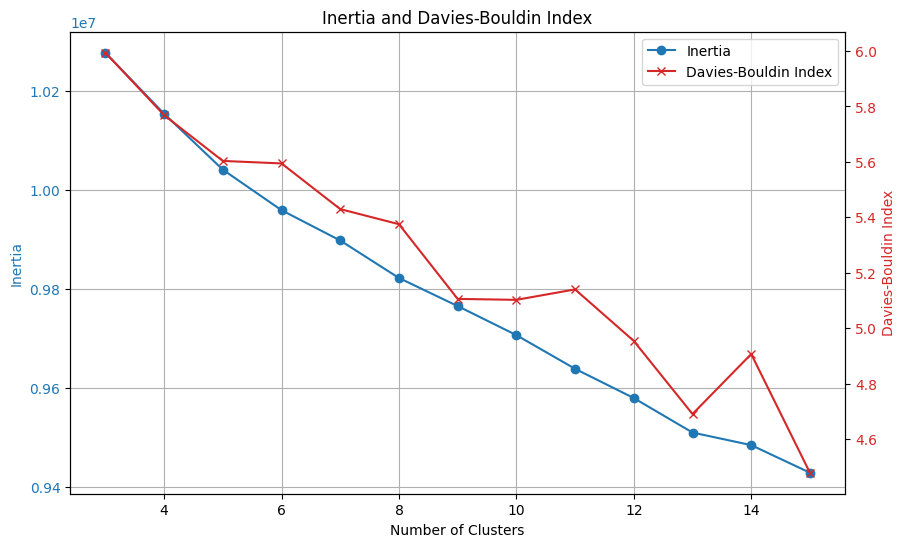

In [29]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot inertia on the first axis
color = 'tab:blue'
ax1.plot(K, inertia_sample, marker='o', color=color, label='Inertia')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a second y-axis sharing the same x-axis and plot Davies-Bouldin Index
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(K, davies_bouldin_sample, marker='x', color=color, label='Davies-Bouldin Index')
ax2.set_ylabel('Davies-Bouldin Index', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0)

plt.title('Inertia and Davies-Bouldin Index')
plt.show()

According to the graph, the optimal number of clusters is 13.

In [30]:
# Number of clusters
n_clusters = 13

# Initialize KMeans with specified number of clusters
sample_clustering = KMeans(n_clusters=n_clusters, n_init=5, random_state=RANDOM_STATE)

# Measure the start time
start_time = timeit.default_timer()

# Fit the KMeans model
sample_clustering.fit(df_base_scale)

# Measure the time taken to fit the model
clustering_fit_time = timeit.default_timer() - start_time

print(f'Clustering fit time: {clustering_fit_time:.2f} seconds')

Clustering fit time: 7.69 seconds


In [31]:
# Measure the start time
start_time = timeit.default_timer()

# Predict cluster labels for the scaled data
df_base_scale_labels = sample_clustering.predict(df_base_scale)

# Measure the time taken for prediction
clustering_predict_time_base = timeit.default_timer() - start_time

print(f'Clustering prediction time: {clustering_predict_time_base:.2f} seconds')

Clustering prediction time: 0.11 seconds


In [32]:
# Create a DataFrame from scaled data with the original index and column names
df_base_scale = pd.DataFrame(df_base_scale, index=df_base.index, columns=x)

# Add the cluster labels
df_base_scale['cluster'] = df_base_scale_labels
df_base_scale.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,cluster
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1026635-base,-0.12,0.42,0.52,-0.86,1.79,-2.48,0.48,0.11,1.83,0.42,0.16,-0.15,-0.29,0.35,0.99,-0.37,-1.03,-0.33,0.95,0.19,-0.19,-0.03,0.60,-0.55,1.63,0.42,0.03,-0.74,-0.79,-0.09,0.79,1.25,-0.67,0.10,0.82,0.75,-0.44,-0.33,1.59,-0.06,-0.08,0.95,2.16,2.54,-0.60,-0.07,3.40,-0.69,1.79,-2.22,1.78,-0.26,-1.04,0.48,0.86,0.77,-0.33,0.29,1.73,-1.42,1.05,-0.31,-0.47,1.00,1.22,1.14,0.50,0.60,-0.48,0.16,-0.72,-0.38,7
4212496-base,-0.50,-1.98,-0.19,-0.47,0.53,0.38,0.06,-0.50,0.40,-2.05,-0.94,-0.08,-0.23,0.42,-0.28,-1.14,-0.25,-1.18,0.76,1.30,-0.31,0.62,1.96,1.18,-0.24,0.42,-1.86,0.38,-1.07,-0.61,1.04,-2.41,-0.24,-1.55,-0.68,-0.75,0.20,0.53,0.91,-0.65,-0.73,0.42,-0.25,0.38,-0.80,-1.28,-0.42,-1.45,-0.78,0.25,0.11,0.14,0.70,-0.06,0.73,-0.60,1.14,0.57,2.07,0.56,-0.71,-2.09,-2.13,0.82,-0.61,0.06,0.97,-1.97,-0.38,0.09,-0.72,-0.14,9
390595-base,0.85,-1.25,1.56,0.51,-0.98,-0.13,-0.75,-0.18,0.26,-1.21,-0.52,-0.12,-2.41,0.23,-0.51,-0.82,-0.42,0.74,-1.29,0.81,0.69,-1.67,0.75,1.40,-1.80,0.42,-0.04,-0.09,-0.36,1.06,-0.05,0.35,0.25,1.19,-0.43,0.63,-0.28,0.05,1.30,-1.28,0.19,1.08,-0.57,-0.35,1.14,-0.58,-0.44,-0.39,-0.13,-0.91,-0.66,-2.14,-0.28,-1.82,-0.30,0.14,1.75,0.37,-1.86,-0.99,1.46,-1.03,0.80,-0.36,1.63,-1.39,0.64,-1.42,-0.03,0.70,0.56,-0.27,5
4133562-base,0.17,0.71,-0.57,0.05,-1.40,-0.36,0.48,-1.25,0.60,-1.76,0.63,1.20,-0.99,-0.99,0.77,0.34,-1.11,-1.52,0.18,-1.45,-1.40,-0.53,-1.45,-1.00,2.37,0.42,-0.69,0.58,0.28,0.30,1.48,0.22,-0.60,0.10,-1.22,0.37,-0.30,-1.14,-0.63,0.43,0.74,0.76,-0.88,-1.44,-1.21,-1.90,0.22,-1.58,0.42,-0.22,1.08,0.08,-0.40,0.42,-2.52,-1.36,1.03,0.92,-0.48,-1.31,-0.99,-0.83,1.16,-0.22,1.92,1.31,0.29,1.48,0.02,2.14,-0.72,0.19,11
78389-base,-1.44,-0.64,0.20,0.00,0.17,0.07,-0.88,-0.63,-0.66,-0.01,0.38,-0.38,-1.36,-1.37,-0.46,-2.70,-0.40,1.79,-1.11,0.76,2.28,0.62,0.48,0.15,0.17,0.42,0.94,-0.77,0.72,0.21,0.50,0.18,-0.92,1.53,-1.51,0.26,-1.32,-2.09,-0.50,-0.42,-1.88,-0.81,-0.72,-0.82,0.10,-2.15,0.98,0.02,0.70,-0.49,1.16,0.84,1.65,-1.92,0.68,0.62,0.68,1.07,0.24,-1.03,-0.34,0.91,-1.43,-0.02,-1.57,1.11,1.15,0.55,-0.53,-0.28,-0.62,-0.41,10


In [33]:
# Measure the start time
start_time = timeit.default_timer()

# Predict cluster labels for the scaled training data
df_train_scale_labels = sample_clustering.predict(df_train_scale)

# Measure the time taken for prediction
clustering_predict_time_train = timeit.default_timer() - start_time

print(f'Clustering prediction time for training data: {clustering_predict_time_train:.2f} seconds')

Clustering prediction time for training data: 0.00 seconds


In [34]:
# Create a DataFrame from scaled data with the original index and column names
df_train_scale = pd.DataFrame(df_train_scale, index=df_train.index, columns=x)

# Add the cluster labels
df_train_scale['cluster'] = df_train_scale_labels
df_train_scale.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,cluster
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
71751-query,-0.39,-0.19,0.16,0.68,0.32,0.47,-1.35,0.51,0.22,0.55,-1.12,-0.28,-0.58,-0.13,-1.23,-0.65,-0.90,1.51,-2.19,0.13,2.28,0.62,0.66,1.00,0.13,-3.73,-1.93,-0.91,1.04,0.75,-0.15,0.12,1.03,-0.33,-0.04,-0.02,-1.13,-1.35,-0.76,1.20,-1.30,2.06,0.93,-0.53,-0.75,-0.21,-1.07,-1.16,0.85,-1.19,2.26,-0.64,-1.34,-0.31,0.71,-2.04,1.46,-1.69,0.56,-1.16,-0.39,0.34,1.49,0.86,0.73,0.01,-1.53,-0.61,-0.56,1.96,1.19,0.39,2
80493-query,0.21,1.88,-0.09,-2.02,-0.14,-0.13,-0.15,0.31,-0.73,0.22,0.32,0.30,1.18,0.01,1.26,-0.33,-0.36,-2.02,-2.06,2.04,-0.52,0.62,-1.17,-0.16,1.69,0.42,-0.75,-0.56,-0.62,-0.67,-0.99,-0.08,-0.21,1.53,0.73,-1.21,0.69,-0.64,1.47,-0.00,-0.54,0.20,-1.29,0.98,-0.41,0.85,-0.10,0.40,-0.52,-1.17,0.47,0.62,-0.38,-1.43,0.12,1.58,0.34,-0.34,-2.68,-0.58,0.84,0.63,0.33,1.94,-0.69,0.35,-1.16,0.40,-0.64,0.39,1.28,0.39,7
2655-query,3.30,0.31,1.47,-0.44,1.78,0.58,-1.35,1.15,0.05,2.86,0.53,0.52,-0.77,0.10,0.11,0.03,1.05,-0.47,0.87,0.50,1.07,0.17,0.49,0.12,-0.26,0.42,-0.95,2.47,-1.37,0.27,0.15,-0.09,-1.41,0.57,-0.93,-0.04,-0.47,-1.34,-1.20,1.71,-1.10,0.55,-0.79,-0.55,1.06,-0.82,-0.75,2.03,0.34,-0.78,-0.30,0.01,0.07,0.23,1.84,0.11,0.14,1.09,0.02,0.50,-0.46,-0.07,0.82,1.25,-0.04,0.87,-0.31,-1.73,-1.61,0.93,1.60,-0.47,5
53233-query,0.52,-0.81,-0.03,-1.20,0.10,-0.17,-1.35,-1.10,1.40,0.73,0.92,1.99,-0.23,-0.38,0.24,0.44,-1.03,-1.42,0.17,0.31,1.29,0.62,0.55,0.36,0.16,0.42,-0.12,-0.76,-1.08,0.58,-0.03,-1.04,1.31,-1.21,0.51,1.73,-0.14,1.72,-0.55,-0.60,0.05,-0.57,-0.74,-0.54,0.91,-1.76,0.30,-0.54,-0.06,1.33,0.85,0.92,-1.22,0.80,1.17,-1.45,-0.17,1.28,-0.31,-0.91,0.12,-0.41,-0.89,-0.84,1.36,-0.47,0.15,0.76,-0.89,0.76,0.22,0.85,3
91141-query,-1.39,-0.43,-0.18,0.71,-1.66,-0.42,-0.51,0.89,-0.14,0.19,-0.25,-0.56,2.13,0.37,-0.10,-0.74,-0.54,-0.02,-0.23,-0.78,-0.49,-1.17,0.34,-0.07,-0.45,0.42,-2.08,-1.50,0.98,-0.49,0.03,0.75,1.03,-1.80,-0.12,-0.49,0.76,-0.98,0.40,1.73,-1.44,-0.72,-1.80,0.57,0.19,0.15,-0.19,0.53,-0.86,-0.27,1.31,1.28,-0.64,0.87,-0.15,0.39,0.46,-1.63,1.87,0.92,0.36,1.83,-0.57,0.27,-0.76,-0.29,-0.80,-0.45,0.48,0.51,0.97,-0.30,11


### Training a NearestNeighbors model for each cluster.

In [35]:
# Measure the start time
start_time = timeit.default_timer()

# Dictionary to store NearestNeighbors models for each cluster
nn_models = {}

# Loop through each cluster label
for cluster_label in range(n_clusters):
    # Filter the database by cluster label
    cluster_products = df_base_scale[df_base_scale['cluster'] == cluster_label]
    
    # Create and train a NearestNeighbors model for the current cluster
    nn_model = NearestNeighbors(n_neighbors=5, n_jobs=-1)
    nn_model.fit(cluster_products[x])
    
    # Save the model in the dictionary
    nn_models[cluster_label] = nn_model

# Measure the time taken to fit all models    
nn_models_fit_time = timeit.default_timer() - start_time

print(f'NearestNeighbors models fitting time: {nn_models_fit_time:.2f} seconds')

NearestNeighbors models fitting time: 0.42 seconds


In [36]:
def find_five_neighbors(row):
    """
    Finds the five nearest neighbors for a given row based on its cluster label.

    Args:
    row (pd.Series): A row from a DataFrame that includes a 'cluster' label and feature values.

    Returns:
    np.ndarray: Indices of the five nearest neighbors.
    """
    # Extract the cluster label of the current object from the row
    cluster_label = row['cluster']
    
    # Extract feature values and reshape for the model
    X = row[x].values.reshape(1, -1)
    
    # Select the NearestNeighbors model corresponding to the cluster label
    model = nn_models[cluster_label]
    
    # Compute the indices of the 5 nearest neighbors
    neighbor_indices = model.kneighbors(X, return_distance=False)
    
    return neighbor_indices[0]

In [37]:
# Measure the start time
start_time = timeit.default_timer()

# Apply the function to find the five nearest neighbors and store the result in a new column
df_train_scale['ids_similar'] = df_train_scale.apply(find_five_neighbors, axis=1)

# Measure the time taken for the operation
nn_models_predict_time = timeit.default_timer() - start_time

print(f'NearestNeighbors prediction time: {nn_models_predict_time:.2f} seconds')

NearestNeighbors prediction time: 7.92 seconds


In [38]:
df_train_scale.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,cluster,ids_similar
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
71751-query,-0.39,-0.19,0.16,0.68,0.32,0.47,-1.35,0.51,0.22,0.55,-1.12,-0.28,-0.58,-0.13,-1.23,-0.65,-0.90,1.51,-2.19,0.13,2.28,0.62,0.66,1.00,0.13,-3.73,-1.93,-0.91,1.04,0.75,-0.15,0.12,1.03,-0.33,-0.04,-0.02,-1.13,-1.35,-0.76,1.20,-1.30,2.06,0.93,-0.53,-0.75,-0.21,-1.07,-1.16,0.85,-1.19,2.26,-0.64,-1.34,-0.31,0.71,-2.04,1.46,-1.69,0.56,-1.16,-0.39,0.34,1.49,0.86,0.73,0.01,-1.53,-0.61,-0.56,1.96,1.19,0.39,2,"[11535, 10966, 2070, 12598, 10044]"
80493-query,0.21,1.88,-0.09,-2.02,-0.14,-0.13,-0.15,0.31,-0.73,0.22,0.32,0.30,1.18,0.01,1.26,-0.33,-0.36,-2.02,-2.06,2.04,-0.52,0.62,-1.17,-0.16,1.69,0.42,-0.75,-0.56,-0.62,-0.67,-0.99,-0.08,-0.21,1.53,0.73,-1.21,0.69,-0.64,1.47,-0.00,-0.54,0.20,-1.29,0.98,-0.41,0.85,-0.10,0.40,-0.52,-1.17,0.47,0.62,-0.38,-1.43,0.12,1.58,0.34,-0.34,-2.68,-0.58,0.84,0.63,0.33,1.94,-0.69,0.35,-1.16,0.40,-0.64,0.39,1.28,0.39,7,"[752, 4254, 767, 6687, 7110]"
2655-query,3.30,0.31,1.47,-0.44,1.78,0.58,-1.35,1.15,0.05,2.86,0.53,0.52,-0.77,0.10,0.11,0.03,1.05,-0.47,0.87,0.50,1.07,0.17,0.49,0.12,-0.26,0.42,-0.95,2.47,-1.37,0.27,0.15,-0.09,-1.41,0.57,-0.93,-0.04,-0.47,-1.34,-1.20,1.71,-1.10,0.55,-0.79,-0.55,1.06,-0.82,-0.75,2.03,0.34,-0.78,-0.30,0.01,0.07,0.23,1.84,0.11,0.14,1.09,0.02,0.50,-0.46,-0.07,0.82,1.25,-0.04,0.87,-0.31,-1.73,-1.61,0.93,1.60,-0.47,5,"[17190, 10816, 20199, 31359, 3377]"
53233-query,0.52,-0.81,-0.03,-1.20,0.10,-0.17,-1.35,-1.10,1.40,0.73,0.92,1.99,-0.23,-0.38,0.24,0.44,-1.03,-1.42,0.17,0.31,1.29,0.62,0.55,0.36,0.16,0.42,-0.12,-0.76,-1.08,0.58,-0.03,-1.04,1.31,-1.21,0.51,1.73,-0.14,1.72,-0.55,-0.60,0.05,-0.57,-0.74,-0.54,0.91,-1.76,0.30,-0.54,-0.06,1.33,0.85,0.92,-1.22,0.80,1.17,-1.45,-0.17,1.28,-0.31,-0.91,0.12,-0.41,-0.89,-0.84,1.36,-0.47,0.15,0.76,-0.89,0.76,0.22,0.85,3,"[3336, 3359, 3020, 1620, 7806]"
91141-query,-1.39,-0.43,-0.18,0.71,-1.66,-0.42,-0.51,0.89,-0.14,0.19,-0.25,-0.56,2.13,0.37,-0.10,-0.74,-0.54,-0.02,-0.23,-0.78,-0.49,-1.17,0.34,-0.07,-0.45,0.42,-2.08,-1.50,0.98,-0.49,0.03,0.75,1.03,-1.80,-0.12,-0.49,0.76,-0.98,0.40,1.73,-1.44,-0.72,-1.80,0.57,0.19,0.15,-0.19,0.53,-0.86,-0.27,1.31,1.28,-0.64,0.87,-0.15,0.39,0.46,-1.63,1.87,0.92,0.36,1.83,-0.57,0.27,-0.76,-0.29,-0.80,-0.45,0.48,0.51,0.97,-0.30,11,"[9773, 12574, 3494, 5457, 9977]"


Let's calculate the accuracy@5 and the total time for this solution.

In [39]:
# Dictionary to store mappings for each cluster
sample_cluster_dicts = {}

for cluster_label in range(n_clusters):
    # Filter the database by cluster label
    cluster_data = df_base_scale[df_base_scale['cluster'] == cluster_label]
    
    # Reset the index
    cluster_data_reset = cluster_data.reset_index()
    
    # Create a dictionary for the current cluster (new index: old index)
    sample_cluster_dict = {new_idx: old_idx for new_idx, old_idx in zip(cluster_data_reset.index, cluster_data_reset['Id'])}
    
    # Add the cluster dictionary to the main dictionary
    sample_cluster_dicts[cluster_label] = sample_cluster_dict


In [40]:
targets = df_train[y]
idx = df_train_scale['ids_similar']
clusters = df_train_scale['cluster']

In [41]:
# Initialize accuracy counter
acc = 0

# Iterate over targets, indices, and clusters
for target, el, cluster in zip(targets.values.tolist(), idx.tolist(), clusters):
    # Get the dictionary for the current cluster
    cluster_dict = sample_cluster_dicts[cluster]
    
    # Check if the target is in the top 5 nearest neighbors
    acc += int(target in [cluster_dict[r] for r in el])

# Calculate baseline accuracy
baseline_acc = 100 * acc / len(idx)

print(f'accuracy@5 = {baseline_acc:.2f}')

accuracy@5 = 65.24


In [42]:
# Calculate the total baseline time
baseline_time = (
    clustering_fit_time + 
    clustering_predict_time_base +
    clustering_predict_time_train +
    nn_models_fit_time +
    nn_models_predict_time
)

print(f'Total search time: {baseline_time:.2f} seconds')

Total search time: 16.14 seconds


**Conclusions:**

* The following algorithm was used to solve the matching problem:
   1. Perform clustering of the database.
   2. Determine the cluster membership for each item in the sample.
   3. Search for the most similar items only within the corresponding cluster.
   

* The solution was implemented using the `sklearn` library. Similarity between objects was calculated using Euclidean distance. The quality metric value is 65.24, and the search time was 16 seconds.

## Apply the FAISS algorithm to the samples.

### FAISS with the parameters from the baseline.

In [43]:
df_train_faiss = df_train_scale[x]
df_train_faiss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
71751-query,-0.39,-0.19,0.16,0.68,0.32,0.47,-1.35,0.51,0.22,0.55,-1.12,-0.28,-0.58,-0.13,-1.23,-0.65,-0.90,1.51,-2.19,0.13,2.28,0.62,0.66,1.00,0.13,-3.73,-1.93,-0.91,1.04,0.75,-0.15,0.12,1.03,-0.33,-0.04,-0.02,-1.13,-1.35,-0.76,1.20,-1.30,2.06,0.93,-0.53,-0.75,-0.21,-1.07,-1.16,0.85,-1.19,2.26,-0.64,-1.34,-0.31,0.71,-2.04,1.46,-1.69,0.56,-1.16,-0.39,0.34,1.49,0.86,0.73,0.01,-1.53,-0.61,-0.56,1.96,1.19,0.39
80493-query,0.21,1.88,-0.09,-2.02,-0.14,-0.13,-0.15,0.31,-0.73,0.22,0.32,0.30,1.18,0.01,1.26,-0.33,-0.36,-2.02,-2.06,2.04,-0.52,0.62,-1.17,-0.16,1.69,0.42,-0.75,-0.56,-0.62,-0.67,-0.99,-0.08,-0.21,1.53,0.73,-1.21,0.69,-0.64,1.47,-0.00,-0.54,0.20,-1.29,0.98,-0.41,0.85,-0.10,0.40,-0.52,-1.17,0.47,0.62,-0.38,-1.43,0.12,1.58,0.34,-0.34,-2.68,-0.58,0.84,0.63,0.33,1.94,-0.69,0.35,-1.16,0.40,-0.64,0.39,1.28,0.39
2655-query,3.30,0.31,1.47,-0.44,1.78,0.58,-1.35,1.15,0.05,2.86,0.53,0.52,-0.77,0.10,0.11,0.03,1.05,-0.47,0.87,0.50,1.07,0.17,0.49,0.12,-0.26,0.42,-0.95,2.47,-1.37,0.27,0.15,-0.09,-1.41,0.57,-0.93,-0.04,-0.47,-1.34,-1.20,1.71,-1.10,0.55,-0.79,-0.55,1.06,-0.82,-0.75,2.03,0.34,-0.78,-0.30,0.01,0.07,0.23,1.84,0.11,0.14,1.09,0.02,0.50,-0.46,-0.07,0.82,1.25,-0.04,0.87,-0.31,-1.73,-1.61,0.93,1.60,-0.47
53233-query,0.52,-0.81,-0.03,-1.20,0.10,-0.17,-1.35,-1.10,1.40,0.73,0.92,1.99,-0.23,-0.38,0.24,0.44,-1.03,-1.42,0.17,0.31,1.29,0.62,0.55,0.36,0.16,0.42,-0.12,-0.76,-1.08,0.58,-0.03,-1.04,1.31,-1.21,0.51,1.73,-0.14,1.72,-0.55,-0.60,0.05,-0.57,-0.74,-0.54,0.91,-1.76,0.30,-0.54,-0.06,1.33,0.85,0.92,-1.22,0.80,1.17,-1.45,-0.17,1.28,-0.31,-0.91,0.12,-0.41,-0.89,-0.84,1.36,-0.47,0.15,0.76,-0.89,0.76,0.22,0.85
91141-query,-1.39,-0.43,-0.18,0.71,-1.66,-0.42,-0.51,0.89,-0.14,0.19,-0.25,-0.56,2.13,0.37,-0.10,-0.74,-0.54,-0.02,-0.23,-0.78,-0.49,-1.17,0.34,-0.07,-0.45,0.42,-2.08,-1.50,0.98,-0.49,0.03,0.75,1.03,-1.80,-0.12,-0.49,0.76,-0.98,0.40,1.73,-1.44,-0.72,-1.80,0.57,0.19,0.15,-0.19,0.53,-0.86,-0.27,1.31,1.28,-0.64,0.87,-0.15,0.39,0.46,-1.63,1.87,0.92,0.36,1.83,-0.57,0.27,-0.76,-0.29,-0.80,-0.45,0.48,0.51,0.97,-0.30


In [44]:
df_base_faiss = df_base_scale[x]
df_base_faiss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1026635-base,-0.12,0.42,0.52,-0.86,1.79,-2.48,0.48,0.11,1.83,0.42,0.16,-0.15,-0.29,0.35,0.99,-0.37,-1.03,-0.33,0.95,0.19,-0.19,-0.03,0.60,-0.55,1.63,0.42,0.03,-0.74,-0.79,-0.09,0.79,1.25,-0.67,0.10,0.82,0.75,-0.44,-0.33,1.59,-0.06,-0.08,0.95,2.16,2.54,-0.60,-0.07,3.40,-0.69,1.79,-2.22,1.78,-0.26,-1.04,0.48,0.86,0.77,-0.33,0.29,1.73,-1.42,1.05,-0.31,-0.47,1.00,1.22,1.14,0.50,0.60,-0.48,0.16,-0.72,-0.38
4212496-base,-0.50,-1.98,-0.19,-0.47,0.53,0.38,0.06,-0.50,0.40,-2.05,-0.94,-0.08,-0.23,0.42,-0.28,-1.14,-0.25,-1.18,0.76,1.30,-0.31,0.62,1.96,1.18,-0.24,0.42,-1.86,0.38,-1.07,-0.61,1.04,-2.41,-0.24,-1.55,-0.68,-0.75,0.20,0.53,0.91,-0.65,-0.73,0.42,-0.25,0.38,-0.80,-1.28,-0.42,-1.45,-0.78,0.25,0.11,0.14,0.70,-0.06,0.73,-0.60,1.14,0.57,2.07,0.56,-0.71,-2.09,-2.13,0.82,-0.61,0.06,0.97,-1.97,-0.38,0.09,-0.72,-0.14
390595-base,0.85,-1.25,1.56,0.51,-0.98,-0.13,-0.75,-0.18,0.26,-1.21,-0.52,-0.12,-2.41,0.23,-0.51,-0.82,-0.42,0.74,-1.29,0.81,0.69,-1.67,0.75,1.40,-1.80,0.42,-0.04,-0.09,-0.36,1.06,-0.05,0.35,0.25,1.19,-0.43,0.63,-0.28,0.05,1.30,-1.28,0.19,1.08,-0.57,-0.35,1.14,-0.58,-0.44,-0.39,-0.13,-0.91,-0.66,-2.14,-0.28,-1.82,-0.30,0.14,1.75,0.37,-1.86,-0.99,1.46,-1.03,0.80,-0.36,1.63,-1.39,0.64,-1.42,-0.03,0.70,0.56,-0.27
4133562-base,0.17,0.71,-0.57,0.05,-1.40,-0.36,0.48,-1.25,0.60,-1.76,0.63,1.20,-0.99,-0.99,0.77,0.34,-1.11,-1.52,0.18,-1.45,-1.40,-0.53,-1.45,-1.00,2.37,0.42,-0.69,0.58,0.28,0.30,1.48,0.22,-0.60,0.10,-1.22,0.37,-0.30,-1.14,-0.63,0.43,0.74,0.76,-0.88,-1.44,-1.21,-1.90,0.22,-1.58,0.42,-0.22,1.08,0.08,-0.40,0.42,-2.52,-1.36,1.03,0.92,-0.48,-1.31,-0.99,-0.83,1.16,-0.22,1.92,1.31,0.29,1.48,0.02,2.14,-0.72,0.19
78389-base,-1.44,-0.64,0.20,0.00,0.17,0.07,-0.88,-0.63,-0.66,-0.01,0.38,-0.38,-1.36,-1.37,-0.46,-2.70,-0.40,1.79,-1.11,0.76,2.28,0.62,0.48,0.15,0.17,0.42,0.94,-0.77,0.72,0.21,0.50,0.18,-0.92,1.53,-1.51,0.26,-1.32,-2.09,-0.50,-0.42,-1.88,-0.81,-0.72,-0.82,0.10,-2.15,0.98,0.02,0.70,-0.49,1.16,0.84,1.65,-1.92,0.68,0.62,0.68,1.07,0.24,-1.03,-0.34,0.91,-1.43,-0.02,-1.57,1.11,1.15,0.55,-0.53,-0.28,-0.62,-0.41


In [45]:
dimension = df_base_faiss.shape[1]
quantiser = faiss.IndexFlatL2(dimension)

In [46]:
index_ss = faiss.IndexIVFFlat(quantiser, dimension, n_clusters)

In [47]:
# Measure the start time for training and adding data to the FAISS index
start_time = timeit.default_timer()

# Train the FAISS index with the base data
# Convert data to contiguous array and float32 type as required by FAISS
index_ss.train(np.ascontiguousarray(df_base_faiss.values).astype('float32'))

# Add the base data to the FAISS index
# Convert data to contiguous array and float32 type for consistency
index_ss.add(np.ascontiguousarray(df_base_faiss.values).astype('float32'))

# Measure the time taken to train and add data to the FAISS index
index_ss_train_time = timeit.default_timer() - start_time

print(f'FAISS index training and data addition time: {index_ss_train_time:.2f} seconds')

FAISS index training and data addition time: 0.39 seconds


In [48]:
index_ss.is_trained

True

In [49]:
# Measure the start time for the FAISS search operation
start_time = timeit.default_timer()

# Perform the search operation using the FAISS index
# Convert the query data to contiguous array and float32 type as required by FAISS
# Search for the 5 nearest neighbors
distances, indices = index_ss.search(np.ascontiguousarray(df_train_faiss.values).astype('float32'), 5)

# Measure the time taken for the FAISS search operation
index_ss_predict_time = timeit.default_timer() - start_time

print(f'FAISS search time: {index_ss_predict_time:.2f} seconds')

FAISS search time: 0.65 seconds


Let's calculate the accuracy@5 and the total time for this solution.

In [50]:
base_index = {k: v for k, v in enumerate(df_base_faiss.index.to_list())}

In [51]:
acc = 0
for target, el in zip(targets.values.tolist(), indices.tolist()):
    acc += int(target in [base_index[r] for r in el])

faiss_ss_acc = 100 * acc / len(indices)
print(f'accuracy@5 = {faiss_ss_acc}')

accuracy@5 = 60.88


In [52]:
faiss_ss_time = index_ss_train_time + index_ss_predict_time
(f'FAISS Total time:: {faiss_ss_time:.2f} seconds')

'FAISS Total time:: 1.04 seconds'

In [53]:
results = pd.DataFrame({
    'model': ['sklearn', 'faiss'],
    'accuracy@5': [baseline_acc, faiss_ss_acc],
    'total_time': [baseline_time, faiss_ss_time]
})

results

,model,accuracy@5,total_time
0,sklearn,65.24,16.14
1,faiss,60.88,1.04


With comparable accuracy, the FAISS model performs significantly faster.

### Changing the number of clusters.

In [54]:
# Loop through different numbers of clusters (from 3 to 15)
for n in range(3, 16):
    # Create a FAISS index with the current number of clusters
    index_ss = faiss.IndexIVFFlat(quantiser, dimension, n)
    
    # Measure the start time for training and searching
    start_time = timeit.default_timer()
    
    index_ss.train(np.ascontiguousarray(df_base_faiss.values).astype('float32'))
    index_ss.add(np.ascontiguousarray(df_base_faiss.values).astype('float32'))
    
    # Search for the 5 nearest neighbors
    distances, indices = index_ss.search(np.ascontiguousarray(df_train_faiss.values).astype('float32'), 5)
    
    # Measure the total time taken for the training and searching
    total_time = timeit.default_timer() - start_time
    
    # Calculate accuracy@5
    acc = 0
    for target, el in zip(targets.values.tolist(), indices.tolist()):
        # Check if the target is among the top 5 nearest neighbors
        acc += int(target in [base_index[r] for r in el])
    
    print(f'{n} clusters: accuracy@5 = {100 * acc / len(indices):.2f}%, Total time = {total_time:.2f} seconds')

3 clusters: accuracy@5 = 61.96%, Total time = 1.98 seconds
4 clusters: accuracy@5 = 66.00%, Total time = 1.65 seconds
5 clusters: accuracy@5 = 63.52%, Total time = 1.37 seconds
6 clusters: accuracy@5 = 59.20%, Total time = 1.53 seconds
7 clusters: accuracy@5 = 63.00%, Total time = 1.48 seconds
8 clusters: accuracy@5 = 61.84%, Total time = 1.21 seconds
9 clusters: accuracy@5 = 63.44%, Total time = 1.14 seconds
10 clusters: accuracy@5 = 62.76%, Total time = 1.04 seconds
11 clusters: accuracy@5 = 63.72%, Total time = 0.96 seconds
12 clusters: accuracy@5 = 64.64%, Total time = 1.01 seconds
13 clusters: accuracy@5 = 60.88%, Total time = 0.90 seconds
14 clusters: accuracy@5 = 61.56%, Total time = 0.90 seconds
15 clusters: accuracy@5 = 64.44%, Total time = 0.80 seconds


By dividing the database into 4 clusters, the quality metric can be improved by 5.12%. However, this will increase the overall processing time from 1 to 2 seconds.

### Changing the scaling method.

Let's use the `RobustScaler` from `sklearn` library.

In [55]:
robust_scaler = RobustScaler()

In [56]:
df_base_rs = robust_scaler.fit_transform(df_base)

In [57]:
df_train_rs = robust_scaler.transform(df_train[x])

In [58]:
index_rs = faiss.IndexIVFFlat(quantiser, dimension, n_clusters)

In [59]:
# Measure the start time for training and adding data to the FAISS index
start_time = timeit.default_timer()

index_rs.train(np.ascontiguousarray(df_base_rs).astype('float32'))
index_rs.add(np.ascontiguousarray(df_base_rs).astype('float32'))

# Measure the time taken for training and adding data to the FAISS index
index_rs_train_time = timeit.default_timer() - start_time

print(f'FAISS index training and data addition time: {index_rs_train_time:.2f} seconds')

FAISS index training and data addition time: 0.30 seconds


In [60]:
index_rs.is_trained

True

In [61]:
# Measure the start time for the FAISS search
start_time = timeit.default_timer()

# Search for the 5 nearest neighbors
distances, indices = index_rs.search(np.ascontiguousarray(df_train_rs).astype('float32'), 5)

# Measure the time taken for the FAISS search 
index_rs_predict_time = timeit.default_timer() - start_time

print(f'FAISS search time: {index_rs_predict_time:.2f} seconds')

FAISS search time: 1.11 seconds


Let's calculate the accuracy@5 and the total time for this solution.

In [62]:
acc = 0
for target, el in zip(targets.values.tolist(), indices.tolist()):
    acc += int(target in [base_index[r] for r in el])

faiss_rs_acc = 100 * acc / len(indices)
print(f'accuracy@5 = {faiss_rs_acc}')

accuracy@5 = 51.76


In [63]:
faiss_rs_time = index_rs_train_time + index_rs_predict_time
(f'FAISS Total time:: {faiss_rs_time:.2f} seconds')

'FAISS Total time:: 1.41 seconds'

In [64]:
# Loop through different numbers of clusters (from 3 to 15)
for n in range(3,16):
    # Create a FAISS index with the current number of clusters
    index_rs = faiss.IndexIVFFlat(quantiser, dimension, n)
    
    # Measure the start time for training and searching
    start_time = timeit.default_timer()
    
    index_rs.train(np.ascontiguousarray(df_base_rs).astype('float32'))
    index_rs.add(np.ascontiguousarray(df_base_rs).astype('float32'))
    
    # Search for the 5 nearest neighbors
    distances, indices = index_rs.search(np.ascontiguousarray(df_train_rs).astype('float32'), 5)
    
    # Measure the total time taken for the training and searching
    total_time = timeit.default_timer() - start_time
    
    # Calculate accuracy@5
    acc = 0
    for target, el in zip(targets.values.tolist(), indices.tolist()):
        acc += int(target in [base_index[r] for r in el])

    print(f'{n} clusters: accuracy@5 = {100 * acc / len(indices):.2f}%, Total time = {total_time:.2f} seconds')    

3 clusters: accuracy@5 = 63.52%, Total time = 2.83 seconds
4 clusters: accuracy@5 = 63.56%, Total time = 3.17 seconds
5 clusters: accuracy@5 = 63.56%, Total time = 3.12 seconds
6 clusters: accuracy@5 = 63.56%, Total time = 2.82 seconds
7 clusters: accuracy@5 = 52.48%, Total time = 1.74 seconds
8 clusters: accuracy@5 = 52.00%, Total time = 1.49 seconds
9 clusters: accuracy@5 = 50.56%, Total time = 1.32 seconds
10 clusters: accuracy@5 = 47.60%, Total time = 1.23 seconds
11 clusters: accuracy@5 = 48.88%, Total time = 0.99 seconds
12 clusters: accuracy@5 = 50.52%, Total time = 1.56 seconds
13 clusters: accuracy@5 = 51.76%, Total time = 1.60 seconds
14 clusters: accuracy@5 = 49.84%, Total time = 1.10 seconds
15 clusters: accuracy@5 = 49.84%, Total time = 1.03 seconds


Changing the scaling method does not improve search quality.

**Conclusions:**

* Using the FAISS library significantly reduces the time required to search for similar objects.
* Reducing the number of clusters does not always improve quality.
* Increasing the metric value by up to 4% does not slow down the model.
* Changing the scaling method increases search time without improving quality.

## Implement and optimize the FAISS algorithm on the full dataset.

FAISS Indexing Method Evaluation Plan:

* Cell probe method with a flat index as coarse quantizer.
* Cell probe method with a HNSW as coarse quantizer.
* Cell probe method with a PQ index as coarse quantizer.


In [65]:
base_ids = {k: v for k, v in enumerate(data_base.index.to_list())}

In [66]:
train_ids = data_train[y]

### Data Standardization

In [67]:
scaler_ss = StandardScaler()

In [68]:
data_base_ss = scaler_ss.fit_transform(data_base)

In [69]:
data_train_ss = scaler_ss.transform(data_train[x])

In [70]:
data_valid_ss = scaler_ss.transform(data_valid)

In [71]:
del data_base
del data_train
del data_valid

### IVF Flat L2

Let's determine the number of clusters to divide the database into to achieve the optimal balance between quality and search time.

In [73]:
dim = data_base_ss.shape[1]
quant = faiss.IndexFlatL2(dim)

In [74]:
# Initialize lists to store accuracy and time results
ivf_f_acc = []
ivf_f_time = []

# Loop through different numbers of clusters (from 100 to 300 in steps of 50)
for n in range(100, 301, 50):
    # Create a FAISS index with the current number of clusters
    index = faiss.IndexIVFFlat(quant, dim, n)
    
    # Measure the start time for training and adding data to the index
    start_time = timeit.default_timer()
    
    # Train the FAISS index with a subset of the base data (first 150,000 rows)
    index.train(np.ascontiguousarray(data_base_ss[:150000, :]).astype('float32'))
    
    # Add the entire database to the FAISS index
    index.add(np.ascontiguousarray(data_base_ss).astype('float32'))
    
    # Search for the 5 nearest neighbors
    dists, ids = index.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
    
    # Measure the total time taken for the training, adding data, and searching
    total_time = timeit.default_timer() - start_time
    
    # Calculate accuracy@5
    acc = 0
    for target, el in zip(train_ids.values.tolist(), ids.tolist()):
        acc += int(target in [base_ids[r] for r in el])
    
    ivf_f_acc.append(100 * acc / len(ids))
    ivf_f_time.append(total_time)
    
    print(f'{n} clusters: accuracy@5 = {100 * acc / len(ids):.2f}%, Total time = {total_time:.2f} seconds')

100 clusters: accuracy@5 = 55.29%, Total time = 223.75 seconds
150 clusters: accuracy@5 = 55.53%, Total time = 58.77 seconds
200 clusters: accuracy@5 = 54.90%, Total time = 58.03 seconds
250 clusters: accuracy@5 = 55.34%, Total time = 46.83 seconds
300 clusters: accuracy@5 = 54.53%, Total time = 26.37 seconds


The optimal balance of quality and time is achieved when the database is divided into 250 clusters.

In [75]:
index_ivf250 = faiss.index_factory(dim, "IVF250,Flat")

In [76]:
index_ivf250.train(np.ascontiguousarray(data_base_ss[:150000, :]).astype('float32'))
index_ivf250.add(np.ascontiguousarray(data_base_ss).astype('float32'))

Let's determine the number of clusters to search.

In [77]:
# Initialize lists to store accuracy and time results for different nprobe values
flat_acc = []
flat_time = []

# List of nprobe values to test
nprobe = [1, 4, 8, 16]

# Loop through the different nprobe values
for n in nprobe:
    index_ivf250.nprobe = n
    
    # Measure the start time for the search operation
    start_time = timeit.default_timer()
    
    # Search for the 5 nearest neighbors
    dists, ids = index_ivf250.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
    
    # Measure the time taken for the search operation
    search_time_ = timeit.default_timer() - start_time
    
    # Calculate accuracy@5
    acc = 0
    for target, el in zip(train_ids.values.tolist(), ids.tolist()):
        acc += int(target in [base_ids[r] for r in el])
        
    flat_acc.append(100 * acc / len(ids))
    flat_time.append(search_time_)
    
    print(f'{n}: accuracy@5 = {100 * acc / len(ids):.2f}%, search time = {search_time_:.2f} seconds')

1: accuracy@5 = 55.34%, search time = 32.80 seconds
4: accuracy@5 = 62.84%, search time = 107.27 seconds
8: accuracy@5 = 64.06%, search time = 217.49 seconds
16: accuracy@5 = 64.75%, search time = 428.92 seconds


### IVF Flat with a HNSW

Let's determine the number of clusters to divide the database into to achieve the optimal balance between quality and search time.

In [78]:
quant = faiss.IndexHNSWFlat(dim, 32)

In [79]:
# Initialize lists to store accuracy and time results for different cluster numbers
ivf_hnsw_acc = []
ivf_hnsw_time = []

# Loop through cluster numbers from 100 to 300, incrementing by 50
for n in range(100, 301, 50):
    index = faiss.IndexIVFFlat(quant, dim, n)
    
    # Measure the start time for the training and adding operations
    start_time = timeit.default_timer()
    
    # Train the index with the first 150,000 samples of the base data
    index.train(np.ascontiguousarray(data_base_ss[:150000, :]).astype('float32'))
    # Add the entire base data to the index
    index.add(np.ascontiguousarray(data_base_ss).astype('float32'))
    
    # Search for the 5 nearest neighbors
    dists, ids = index.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
    
    # Measure the total time taken for training, adding, and searching operations
    total_time = timeit.default_timer() - start_time
    
    # Calculate accuracy@5
    acc = 0
    for target, el in zip(train_ids.values.tolist(), ids.tolist()):
        acc += int(target in [base_ids[r] for r in el])
    
    ivf_hnsw_acc.append(100 * acc / len(ids))
    ivf_hnsw_time.append(total_time)
            
    print(f'{n} : accuracy@5 = {100 * acc / len(ids):.2f}%, Total time = {total_time:.2f} seconds')

100 : accuracy@5 = 55.26%, Total time = 195.55 seconds
150 : accuracy@5 = 55.15%, Total time = 86.12 seconds
200 : accuracy@5 = 54.41%, Total time = 120.94 seconds
250 : accuracy@5 = 54.63%, Total time = 40.07 seconds
300 : accuracy@5 = 54.33%, Total time = 35.53 seconds


The optimal number of clusters is 250.

In [80]:
index_ivf_hnsw = faiss.IndexIVFFlat(quant, dim, 250)

In [81]:
index_ivf_hnsw.train(np.ascontiguousarray(data_base_ss[:150000, :]).astype('float32'))
index_ivf_hnsw.add(np.ascontiguousarray(data_base_ss).astype('float32'))

Let's determine the number of clusters to search.

In [82]:
# Initialize lists to store accuracy and search time results for different nprobe values
hnsw_acc = []
hnsw_time = []

# List of nprobe values to test
nprobe = [1, 4, 8, 16]

# Loop through each nprobe value
for n in nprobe:
    index_ivf_hnsw.nprobe = n
    
    # Measure the start time for the search operation
    start_time = timeit.default_timer()
    
    # Search for the 5 nearest neighbors    
    dists, ids = index_ivf_hnsw.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
    
    
    # Measure the total time taken for the search operation
    search_time_ = timeit.default_timer() - start_time
    
    # Calculate accuracy@5
    acc = 0
    for target, el in zip(train_ids.values.tolist(), ids.tolist()):
        acc += int(target in [base_ids[r] for r in el])
        
    hnsw_acc.append(100 * acc / len(ids))
    hnsw_time.append(search_time_)
    
    print(f'{n}: accuracy@5 = {100 * acc / len(ids):.2f}%, search time = {search_time_:.2f} seconds')

1: accuracy@5 = 54.50%, search time = 32.33 seconds
4: accuracy@5 = 62.28%, search time = 107.07 seconds
8: accuracy@5 = 63.54%, search time = 220.92 seconds
16: accuracy@5 = 64.30%, search time = 440.53 seconds


###  IVF with a PQ index

Let's determine the number of clusters to divide the database into to achieve the optimal balance between quality and search time.

In [83]:
quant = faiss.IndexFlatL2(dim)

In [84]:
# Initialize lists to store accuracy and search time results for different number of clusters
ivf_pq_acc = []
ivf_pq_time = []

# Loop through each cluster size (100, 150, 200, 250, 300)
for n in range(100, 301, 50):
    # Create an IVF-PQ index with n clusters, and 8 sub-quantizers with 8 bits each
    index = faiss.IndexIVFPQ(quant, dim, n, 8, 8)
    
    # Measure the start time for the training and adding operation    
    start_time = timeit.default_timer()
    
    # Train the index on the first 150,000 samples of the base data
    index.train(np.ascontiguousarray(data_base_ss[:150000, :]).astype('float32'))
    # Add the entire base data to the index
    index.add(np.ascontiguousarray(data_base_ss).astype('float32'))
    
    # Search the index for the 5 nearest neighbors
    dists, ids = index.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
    
    # Measure the total time taken for training, adding, and searching
    total_time = timeit.default_timer() - start_time
    
    # Calculate accuracy@5
    acc = 0
    for target, el in zip(train_ids.values.tolist(), ids.tolist()):
        acc += int(target in [base_ids[r] for r in el])

    ivf_pq_acc.append(100 * acc / len(ids))
    ivf_pq_time.append(total_time)
                    
    print(f'{n} : accuracy@5 = {100 * acc / len(ids):.2f}%, Total time = {total_time:.2f} seconds')

100 : accuracy@5 = 50.19%, Total time = 385.53 seconds
150 : accuracy@5 = 50.70%, Total time = 93.16 seconds
200 : accuracy@5 = 50.49%, Total time = 65.89 seconds
250 : accuracy@5 = 50.87%, Total time = 43.94 seconds
300 : accuracy@5 = 50.39%, Total time = 38.24 seconds


The optimal number of clusters is 250.

In [85]:
index_ivf_pq = faiss.IndexIVFPQ(quant, dim, 250, 8, 8)

In [86]:
index_ivf_pq.train(np.ascontiguousarray(data_base_ss[:150000, :]).astype('float32'))
index_ivf_pq.add(np.ascontiguousarray(data_base_ss).astype('float32'))

Let's determine the number of clusters to search.

In [87]:
# Initialize lists to store accuracy and search time results for different nprobe values
pq_acc = []
pq_time = []

# List of nprobe values to test
nprobe = [1, 4, 8, 16]

# Loop through each nprobe value
for n in nprobe:
    index_ivf_pq.nprobe = n
    
    # Measure the start time for the search operation
    start_time = timeit.default_timer()
    
    # Search the 5 nearest neighbors
    dists, ids = index_ivf_pq.search(np.ascontiguousarray(data_train_ss).astype('float32'), 5)
    
    # Measure the total time
    search_time_ = timeit.default_timer() - start_time
    
    # Calculate accuracy@5
    acc = 0
    for target, el in zip(train_ids.values.tolist(), ids.tolist()):
        acc += int(target in [base_ids[r] for r in el])
        
    pq_acc.append(100 * acc / len(ids))
    pq_time.append(search_time_)
    
    print(f'{n}: accuracy@5 = {100 * acc / len(ids):.2f}%, search time = {search_time_:.2f} sec')

1: accuracy@5 = 50.87%, search time = 10.91 sec
4: accuracy@5 = 56.73%, search time = 14.90 sec
8: accuracy@5 = 57.54%, search time = 29.62 sec
16: accuracy@5 = 57.94%, search time = 56.94 sec


### Choosing the best model.

Let's summarize the results in a table.

In [97]:
row = list(range(100, 301, 50))

models = ['IVF_Flat', 'IVF_HNSW', 'IVF_PQ']
acc_data = [ivf_f_acc, ivf_hnsw_acc, ivf_pq_acc]
time_data = [ivf_f_time, ivf_hnsw_time, ivf_pq_time]

data = {}
for i, model in enumerate(models):
    data[f'{model}_acc'] = acc_data[i]
    data[f'{model}_time'] = time_data[i]
    
df_1 = pd.DataFrame(data, index=row)
df_1 = df_1.rename_axis('n_list')
df_1

,IVF_Flat_acc,IVF_Flat_time,IVF_HNSW_acc,IVF_HNSW_time,IVF_PQ_acc,IVF_PQ_time
n_list,,,,,,
100,55.29,223.75,55.26,195.55,50.19,385.53
150,55.53,58.77,55.15,86.12,50.70,93.16
200,54.90,58.03,54.41,120.94,50.49,65.89
250,55.34,46.83,54.63,40.07,50.87,43.94
300,54.53,26.37,54.33,35.53,50.39,38.24


All models demonstrated the best balance between quality and speed with the database partitioned into 250 clusters.

In [98]:
row = nprobe

acc_data = [flat_acc, hnsw_acc, pq_acc]
time_data = [flat_time, hnsw_time, pq_time]

data = {}
for i, model in enumerate(models):
    data[f'{model}_acc'] = acc_data[i]
    data[f'{model}_time'] = time_data[i]
    
df_2 = pd.DataFrame(data, index=row)
df_2 = df_2.rename_axis('nprobe')
df_2

,IVF_Flat_acc,IVF_Flat_time,IVF_HNSW_acc,IVF_HNSW_time,IVF_PQ_acc,IVF_PQ_time
nprobe,,,,,,
1,55.34,32.80,54.50,32.33,50.87,10.91
4,62.84,107.27,62.28,107.07,56.73,14.90
8,64.06,217.49,63.54,220.92,57.54,29.62
16,64.75,428.92,64.30,440.53,57.94,56.94


The highest quality metric value is 64.75, with a search time of 7 minutes. When the search time is reduced by half, the quality metric decreases by less than 1%. Therefore, the optimal solution is to choose the "IVF250,Flat" index with `nprobe=8`.

**Conclusion:**

The FAISS index `IndexIVFFlat`, with the database partitioned into 250 cells and 8 search probes, provides the best balance between quality and speed for the training dataset.








## Test the best model.

In [90]:
index_ivf250_np8 = faiss.index_factory(dim, "IVF250,Flat")

In [91]:
index_ivf250_np8.nprobe = 8

In [92]:
start_time = timeit.default_timer()

index_ivf250_np8.train(np.ascontiguousarray(data_base_ss[:150000, :]).astype('float32'))
index_ivf250_np8.add(np.ascontiguousarray(data_base_ss).astype('float32'))
train_time = timeit.default_timer() - start_time

print(f'FAISS index training and data addition time: {train_time:.2f} seconds')

FAISS index training and data addition time: 28.69 seconds


In [93]:
index_ivf250_np8.is_trained

True

In [94]:
start_time = timeit.default_timer()

dists, ids = index_ivf250_np8.search(np.ascontiguousarray(data_valid_ss).astype('float32'), 5)

search_time = timeit.default_timer() - start_time

In [95]:
targets = data_valid_answer['expected']

In [96]:
acc = 0
for target, el in zip(targets.values.tolist(), ids.tolist()):
    acc += int(target in [base_ids[r] for r in el])

print(f'accuracy@5 = {100 * acc / len(ids)}')
print(f'training time {train_time:.2f} seconds')
print(f'search time {search_time:.2f} seconds')

accuracy@5 = 63.889
training time 28.69 seconds
search time 222.74 seconds


## General Conclusions.

The goal of this project was to perform product matching, which involved identifying the most similar products from two datasets.

The data provided for analysis consists of four sets: a database, training and validation datasets, and answers for the validation dataset.

The database contains a list of 2.9 million products and their characteristics. These characteristics are encrypted. Both the training and validation datasets consist of 100 thousand products, each of which has a corresponding match in the database.

During the preprocessing stage, style errors in column names were corrected. No missing values or complete duplicates were found.

To reduce the runtime of models during the parameter selection process, a decision was made to create a sample from the training dataset and the database.

To address the task outlined in the project, the following algorithm was chosen:

1.	Perform clustering on the database.
1.	Determine the cluster membership for each product in the sample.
1.	Search for the most similar products only within the corresponding cluster.

The data was scaled using the `StandardScaler` method from the `sklearn` library.

The chosen algorithm was implemented using the sklearn and FAISS libraries on the samples. With similar parameters (13 clusters and Euclidean distance as the similarity measure), the models demonstrated comparable quality, but the FAISS model works significantly faster.

It was found that reducing the number of clusters in the FAISS model does not always lead to an improvement in quality but does increase processing time. Changing the scaling method does not lead to an increase in quality.

Next, the algorithm was implemented on the entire dataset using the FAISS library. The performance of models with Cell probe method was analyzed using:

* Flat index as coarse quantizer
* HNSW quantizer (Hierarchical Navigable Small World)
* PQ quantizer (Product Quantizer)

As a result of comparing quality and time ratios, the IndexIVFFlat model (Inverted file with exact post-verification) was recognized as the best. This model splits the database into 250 clusters and performs 8 search queries. In less than 4 minutes on the training set, the model achieved a quality metric of 64.06.

Testing the model on the validation set yielded the following results:

* accuracy@5 = 63.889
* Training time: 29 seconds
* Search time without training: 223 seconds

In other words, for a set of 100,000 items, the model can find similar items in an almost three-million-item database in less than 4 minutes, accurately identifying 3 out of 5 items. Therefore, it can be stated that the main goal of the project has been achieved.